<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/2019_tf/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series / Sequences

Example, some code and a lot of inspiration taken from: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/


## Univariate Sequences

just one variable per time step

### Challenge

We have a known series of events, possibly in time and you want to know what is the next event. Like this

[10, 20, 30, 40, 50, 60, 70, 80, 90]

In [0]:
# univariate data preparation
import numpy as np

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [2]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# choose a number of time steps
n_steps = 3

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# summarize the data
list(zip(X, y))

[(array([10, 20, 30]), 40),
 (array([20, 30, 40]), 50),
 (array([30, 40, 50]), 60),
 (array([40, 50, 60]), 70),
 (array([50, 60, 70]), 80),
 (array([60, 70, 80]), 90)]

In [3]:
X

array([[10, 20, 30],
       [20, 30, 40],
       [30, 40, 50],
       [40, 50, 60],
       [50, 60, 70],
       [60, 70, 80]])

### Converting shapes

* one of the most frequent, yet most tedious steps
* match between what you have and what an interface needs
* expected input of RNN: 3D tensor featureswith shape (samples, timesteps, input_dim)
* we have: (samples, timesteps)
* reshape on np arrays can do all that

In [4]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X

array([[[10],
        [20],
        [30]],

       [[20],
        [30],
        [40]],

       [[30],
        [40],
        [50]],

       [[40],
        [50],
        [60]],

       [[50],
        [60],
        [70]],

       [[60],
        [70],
        [80]]])

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.models import Sequential, Model

model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
model.add(Dense(units=1, name="Linear_Output"))
model.compile(optimizer='adam', loss='mse')

In [6]:
%time history = model.fit(X, y, epochs=500, verbose=0)

CPU times: user 1.58 s, sys: 56.5 ms, total: 1.64 s
Wall time: 1.3 s


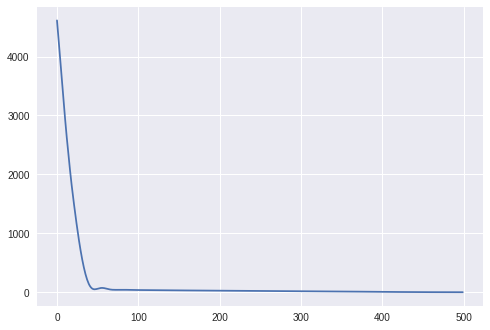

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

In [8]:
# this does not look too bad
X_sample = np.array([[10, 20, 30], [70, 80, 90]])
X_sample = X_sample.reshape((X_sample.shape[0], X_sample.shape[1], n_features))
X_sample

array([[[10],
        [20],
        [30]],

       [[70],
        [80],
        [90]]])

In [9]:
y_pred = model.predict(X_sample)
y_pred

array([[ 38.85929],
       [100.90913]], dtype=float32)

In [0]:
def predict(model, samples, n_features=1):
  input = np.array(samples)
  input = input.reshape((input.shape[0], input.shape[1], n_features))
  y_pred = model.predict(input)
  return y_pred

In [11]:
# do not look too close, though
predict(model, [[100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[133.06836],
       [240.18936],
       [482.26587]], dtype=float32)

### Input and output of an RNN layer

In [12]:
# https://keras.io/layers/recurrent/
# input: (samples, timesteps, input_dim)
# output: (samples, units)

# let's have a look at the actual output for an example
rnn_layer = model.get_layer("RNN_Input")
model_stub = Model(inputs = model.input, outputs = rnn_layer.output)
hidden = predict(model_stub, [[10, 20, 30]])
hidden

array([[ 6.312214  ,  0.        ,  0.        ,  7.8945413 ,  0.        ,
         0.        ,  8.674644  , 10.3216095 ,  0.        ,  0.        ,
        10.498358  , 11.888763  ,  8.759704  ,  0.        , 12.425329  ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , 13.695377  ,  0.        ,  0.        ,  0.71732473,
         0.        ,  0.        ,  0.        ,  9.951456  ,  0.        ,
        12.402657  , 10.01326   , 10.412435  ,  2.1506536 ,  0.        ,
         0.        ,  0.        ,  0.        , 23.847918  ,  0.        ,
         0.        ,  0.        ,  8.327042  ,  0.        ,  0.        ,
        13.307503  ,  0.        ,  6.722261  ,  0.40568876, 13.559036  ]],
      dtype=float32)

#### What do we see?
* each unit (50) has a single output
* as a sidenote you nicely see the RELU nature of the output
* so the timesteps are lost
* we are only looking at the final output
* still with each timestep, the layer does produce a unique output we can use

### We need to look into RNNs a bit more deeply now

#### RNNs - Networks with Loops
<img src='https://djcordhose.github.io/ai/img/nlp/colah/RNN-rolled.png' height=200>

http://colah.github.io/posts/2015-08-Understanding-LSTMs/
#### Unrolling the loop
<img src='https://djcordhose.github.io/ai/img/nlp/colah/RNN-unrolled.png'>

http://colah.github.io/posts/2015-08-Understanding-LSTMs/
#### Simple RNN internals

<img src='https://djcordhose.github.io/ai/img/nlp/fchollet_rnn.png'>

##  $output_t = \tanh(W input_t + U output_{t-1} + b)$

From Deep Learning with Python, Chapter 6, François Chollet, Manning: https://livebook.manning.com/#!/book/deep-learning-with-python/chapter-6/129

#### Activation functions

<img src='https://djcordhose.github.io/ai/img/sigmoid-activation.png' height=200>

Sigmoid compressing between 0 and 1

<img src='https://djcordhose.github.io/ai/img/tanh-activation.png' height=200>

Hyperbolic tangent, like sigmoind, but compressing between -1 and 1, thus allowing for negative values as well

## Advanced part follows

In [13]:
# https://arxiv.org/ftp/arxiv/papers/1701/1701.05923.pdf
# n = output dimension
# m = input dimension
# Total number of parameters for 
# Simple RNN = n**2 + nm + n
# GRU = 3 × (n**2 + nm + n)
# LSTM = 4 × (n**2 + nm + n)

rnn_units = 1

model = Sequential()
model.add(SimpleRNN(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
# model.add(GRU(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_Input (SimpleRNN)        (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [14]:
output_dimension = rnn_units
input_dimension = n_features
parameters = 1 * (output_dimension ** 2 +  output_dimension * input_dimension + output_dimension) 
parameters

3

In [15]:
# from only a single output for the final timestep
# ideal for feeding into something that *does not* handle timesteps
rnn_units = 1
model = Sequential([
    SimpleRNN(units=rnn_units, activation='relu', input_shape=(n_steps, n_features))
])
predict(model, [[10, 20, 30]])

array([[58.223083]], dtype=float32)

### Multi Layer RNNs

In [16]:
# to one output for each timestep
# ideal for feeding into something that *expects* timesteps
rnn_units = 1
model = Sequential([
    SimpleRNN(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), return_sequences=True)
])

# https://keras.io/layers/recurrent/
# input: (samples, timesteps, input_dim)
# output with return_sequences: (samples, timesteps, units)

predict(model, [[10, 20, 30]])

array([[[ 7.988285],
        [23.964855],
        [47.92971 ]]], dtype=float32)

In [17]:
rnn_units = 50

model = Sequential([
    SimpleRNN(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), return_sequences=True, name="RNN_Input"),
    SimpleRNN(units=rnn_units, activation='relu', name="RNN_Latent"),
    Dense(units=1, name="Linear_Output")
])
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_Input (SimpleRNN)        (None, 3, 50)             2600      
_________________________________________________________________
RNN_Latent (SimpleRNN)       (None, 50)                5050      
_________________________________________________________________
Linear_Output (Dense)        (None, 1)                 51        
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________


CPU times: user 2.51 s, sys: 58.4 ms, total: 2.57 s
Wall time: 2.01 s


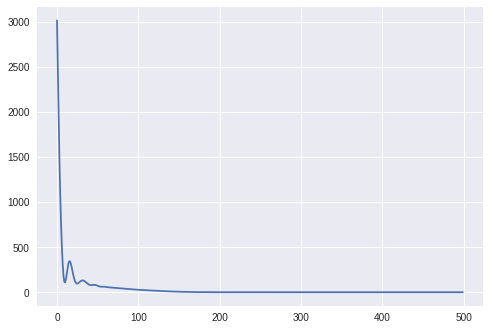

In [18]:
%time history = model.fit(X, y, epochs=500, verbose=0)
plt.plot(history.history['loss'])

In [19]:
predict(model, [[10, 20, 30], [70, 80, 90], [100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[ 40.016705],
       [101.12904 ],
       [134.53055 ],
       [246.12546 ],
       [490.72736 ]], dtype=float32)

### Bidirectional RNNs

In [0]:
rnn_units = 50

model = Sequential([
    Bidirectional(SimpleRNN(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input")),
    Dense(units=1, name="Linear_Output")
])
model.compile(optimizer='adam', loss='mse')

CPU times: user 2.92 s, sys: 76.3 ms, total: 3 s
Wall time: 2.5 s


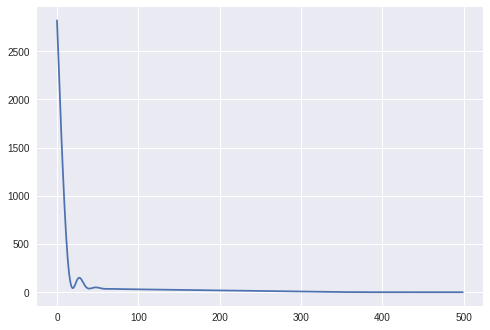

In [21]:
%time history = model.fit(X, y, epochs=500, verbose=0)
plt.plot(history.history['loss'])

In [22]:
predict(model, [[10, 20, 30], [70, 80, 90], [100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[ 39.936214],
       [100.38759 ],
       [131.34027 ],
       [234.24709 ],
       [491.69153 ]], dtype=float32)

### LSMTs / GRUs

* mainly beneficial for long sequences
* but also 3-4 times more expensive
* might not have better results for short sequences like these

In [23]:
rnn_units = 50

model = Sequential([
    LSTM(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"),
    Dense(units=1, name="Linear_Output")
])
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_Input (LSTM)             (None, 50)                10400     
_________________________________________________________________
Linear_Output (Dense)        (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [24]:
output_dimension = rnn_units
input_dimension = n_features
parameters = 4 * (output_dimension ** 2 +  output_dimension * input_dimension + output_dimension) 
parameters

10400

CPU times: user 4.78 s, sys: 154 ms, total: 4.93 s
Wall time: 3.74 s


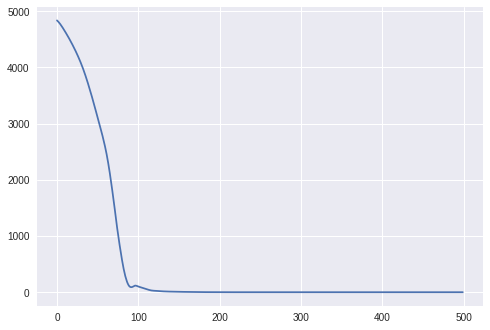

In [25]:
%time history = model.fit(X, y, epochs=500, verbose=0)
plt.plot(history.history['loss'])

In [26]:
predict(model, [[10, 20, 30], [70, 80, 90], [100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[ 40.0106 ],
       [103.86981],
       [144.77574],
       [285.70535],
       [359.83347]], dtype=float32)

In [27]:
rnn_units = 50

model = Sequential([
    GRU(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"),
    Dense(units=1, name="Linear_Output")
])
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_Input (GRU)              (None, 50)                7800      
_________________________________________________________________
Linear_Output (Dense)        (None, 1)                 51        
Total params: 7,851
Trainable params: 7,851
Non-trainable params: 0
_________________________________________________________________


In [28]:
output_dimension = rnn_units
input_dimension = n_features
parameters = 3 * (output_dimension ** 2 +  output_dimension * input_dimension + output_dimension) 
parameters

7800

CPU times: user 4.49 s, sys: 108 ms, total: 4.6 s
Wall time: 3.6 s


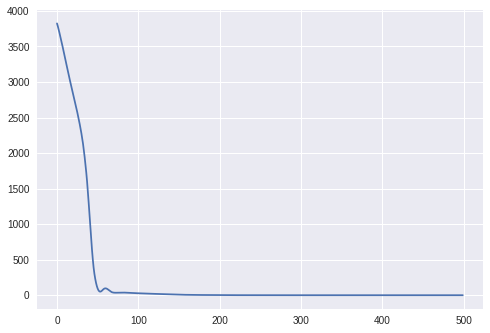

In [29]:
%time history = model.fit(X, y, epochs=500, verbose=0)
plt.plot(history.history['loss'])

In [30]:
predict(model, [[10, 20, 30], [70, 80, 90], [100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[ 39.999657],
       [102.85135 ],
       [141.43193 ],
       [267.96152 ],
       [420.1227  ]], dtype=float32)

## Multivariate LSTM Models

### Multiple Input Series

In [31]:
in_seq1 = [10, 20, 30, 40, 50, 60, 70, 80, 90]
in_seq2 = [15, 25, 35, 45, 55, 65, 75, 85, 95]
out_seq = [in1 + in2 for in1, in2 in zip(in_seq1, in_seq2)]
out_seq

[25, 45, 65, 85, 105, 125, 145, 165, 185]

In [32]:
# convert to [rows, columns] structure
in_seq1 = np.array(in_seq1).reshape((len(in_seq1), 1))
in_seq2 = np.array(in_seq2).reshape((len(in_seq2), 1))
out_seq = np.array(out_seq).reshape((len(out_seq), 1))
out_seq

array([[ 25],
       [ 45],
       [ 65],
       [ 85],
       [105],
       [125],
       [145],
       [165],
       [185]])

In [33]:
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [0]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [35]:
# choose a number of time steps
n_steps = 3

# convert into input/output
X, y = split_sequences(dataset, n_steps)

# summarize the data
list(zip(X, y))

[(array([[10, 15],
         [20, 25],
         [30, 35]]), 65), (array([[20, 25],
         [30, 35],
         [40, 45]]), 85), (array([[30, 35],
         [40, 45],
         [50, 55]]), 105), (array([[40, 45],
         [50, 55],
         [60, 65]]), 125), (array([[50, 55],
         [60, 65],
         [70, 75]]), 145), (array([[60, 65],
         [70, 75],
         [80, 85]]), 165), (array([[70, 75],
         [80, 85],
         [90, 95]]), 185)]

In [0]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

# define model
model = Sequential()
model.add(GRU(units=50, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
model.add(Dense(units=1, name="Linear_Output"))
model.compile(optimizer='adam', loss='mse')

CPU times: user 4.18 s, sys: 122 ms, total: 4.3 s
Wall time: 3.35 s


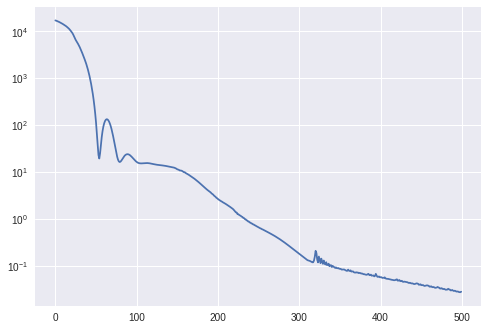

In [37]:
# fit model
%time history = model.fit(X, y, epochs=500, verbose=0)
import matplotlib.pyplot as plt

plt.yscale('log')
plt.plot(history.history['loss'])

In [0]:
def predict_multi(model, samples):
  input = np.array(samples)
  input = input.reshape(1, input.shape[0], input.shape[1])
  y_pred = model.predict(input)
  return y_pred

In [39]:
predict_multi(model, [[80, 85], [90, 95], [100, 105]])

array([[206.78265]], dtype=float32)

In [40]:
predict_multi(model, [[10, 15], [20, 25], [30, 35]])

array([[64.88253]], dtype=float32)

In [41]:
predict_multi(model, [[180, 185], [190, 195], [200, 205]])

array([[423.78033]], dtype=float32)

#### Let's make this a little bit harder

* output y can be inferred from final timestep
* now we try to infer following ouput

In [42]:
y += 20
list(zip(X, y))

[(array([[10, 15],
         [20, 25],
         [30, 35]]), 85), (array([[20, 25],
         [30, 35],
         [40, 45]]), 105), (array([[30, 35],
         [40, 45],
         [50, 55]]), 125), (array([[40, 45],
         [50, 55],
         [60, 65]]), 145), (array([[50, 55],
         [60, 65],
         [70, 75]]), 165), (array([[60, 65],
         [70, 75],
         [80, 85]]), 185), (array([[70, 75],
         [80, 85],
         [90, 95]]), 205)]

CPU times: user 11.2 s, sys: 365 ms, total: 11.5 s
Wall time: 7.74 s


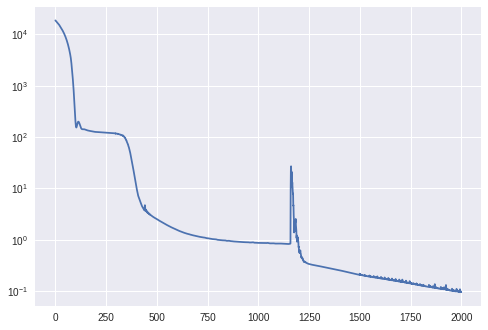

In [43]:
model = Sequential()
model.add(GRU(units=50, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
model.add(Dense(units=1, name="Linear_Output"))
model.compile(optimizer='adam', loss='mse')

# train a little bit longer, as this should be harder now
%time history = model.fit(X, y, epochs=2000, verbose=0)
import matplotlib.pyplot as plt

plt.yscale('log')
plt.plot(history.history['loss'])

In [44]:
predict_multi(model, [[80, 85], [90, 95], [100, 105]])

array([[228.60007]], dtype=float32)

In [45]:
predict_multi(model, [[10, 15], [20, 25], [30, 35]])

array([[84.943115]], dtype=float32)

In [46]:
predict_multi(model, [[180, 185], [190, 195], [200, 205]])

array([[461.72055]], dtype=float32)

## Multi-Step LSTM Models
* this might just as well be an encoder / decoder approach

In [47]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# summarize the data
for input, output in zip(X, y):
  print (input, output)

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


In [0]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(GRU(100, activation='relu', input_shape=(n_steps_in, n_features)))
# model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
# model.add(GRU(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

CPU times: user 5.59 s, sys: 143 ms, total: 5.73 s
Wall time: 4.23 s


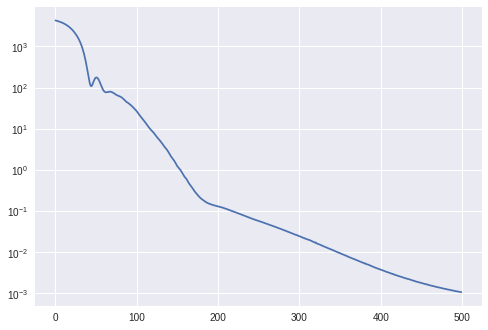

In [49]:
# fit model
%time history = model.fit(X, y, epochs=500, verbose=0)
import matplotlib.pyplot as plt

plt.yscale('log')
plt.plot(history.history['loss'])

In [50]:
X_sample = np.array([70, 80, 90]).reshape((1, n_steps_in, n_features))
y_pred = model.predict(X_sample)
print(y_pred)

[[104.24542 116.23607]]


In [51]:
X_sample = np.array([10, 20, 30]).reshape((1, n_steps_in, n_features))
y_pred = model.predict(X_sample)
print(y_pred)

[[39.993275 50.004936]]
